In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
easy = pd.read_csv('../ocr_evaluation_easyocr_dec1.csv')
pytess = pd.read_csv('../ocr_evaluation_pytesseract_dec1.csv')
paddle = pd.read_csv('../ocr_evaluation_paddle_dec1.csv')

In [ ]:
# Clean up correct labels -- SKIP

# COUNTRY
# if a word in 'country_pred' matches a word in 'country_true', set country_correct to True
def check_country_correct(row):
    true_words = str(row['country_true']).lower().split()
    pred_words = str(row['country_pred']).lower().split()
    for word in pred_words:
        if word in true_words:
            return True
    return False

easy['country_correct'] = easy.apply(check_country_correct, axis=1)
pytess['country_correct'] = pytess.apply(check_country_correct, axis=1)
paddle['country_correct'] = paddle.apply(check_country_correct, axis=1)

# MATERIAL
def check_material_correct(row):
    true_words = str(row['material_true']).lower().split()
    pred_words = str(row['material_pred']).lower().split()
    for word in pred_words:
        if word in true_words:
            return True
    return False
easy['material_correct'] = easy.apply(check_material_correct, axis=1)
pytess['material_correct'] = pytess.apply(check_material_correct, axis=1)
paddle['material_correct'] = paddle.apply(check_material_correct, axis=1)

# CARE

def check_care_correct(row):
    true_words = str(row['care_true']).lower().split()
    pred_words = str(row['care_pred']).lower().split()
    for word in pred_words:
        if word in true_words:
            return True
    return False
easy['care_correct'] = easy.apply(check_care_correct, axis=1)
pytess['care_correct'] = pytess.apply(check_care_correct, axis=1)
paddle['care_correct'] = paddle.apply(check_care_correct, axis=1)


In [ ]:
# Count fuzzy matches > 0.5 for each model and field
print("="*60)
print("FUZZY MATCH COUNTS (score > 0.5)")
print("="*60)

for df_name, df in [('EasyOCR', easy), ('Pytesseract', pytess)]:
    print(f"\n{df_name}:")
    
    # Country
    country_above_threshold = (df['country_fuzzy'] > 0.5).sum()
    country_total = df['country_fuzzy'].notna().sum()
    country_pct = (country_above_threshold / country_total * 100) if country_total > 0 else 0
    
    # Material
    material_above_threshold = (df['material_fuzzy'] > 0.5).sum()
    material_total = df['material_fuzzy'].notna().sum()
    material_pct = (material_above_threshold / material_total * 100) if material_total > 0 else 0
    
    # Care
    care_above_threshold = (df['care_fuzzy'] > 0.5).sum()
    care_total = df['care_fuzzy'].notna().sum()
    care_pct = (care_above_threshold / care_total * 100) if care_total > 0 else 0
    
    print(f"  Country:  {country_above_threshold}/{country_total} ({country_pct:.1f}%)")
    print(f"  Material: {material_above_threshold}/{material_total} ({material_pct:.1f}%)")
    print(f"  Care:     {care_above_threshold}/{care_total} ({care_pct:.1f}%)")



MODEL COMPARISON - Fuzzy Match Performance
      Model  Country (>0.5)  Material (>0.5)  Care (>0.5)  Country Avg  Material Avg  Care Avg
    EasyOCR       77.906977        80.232558    88.372093    76.923619     70.430608 83.363584
Pytesseract       66.279070        75.581395    89.534884    65.793944     69.954141 82.314364
  PaddleOCR        0.000000         1.162791     0.000000     0.000000      1.162791  0.000000




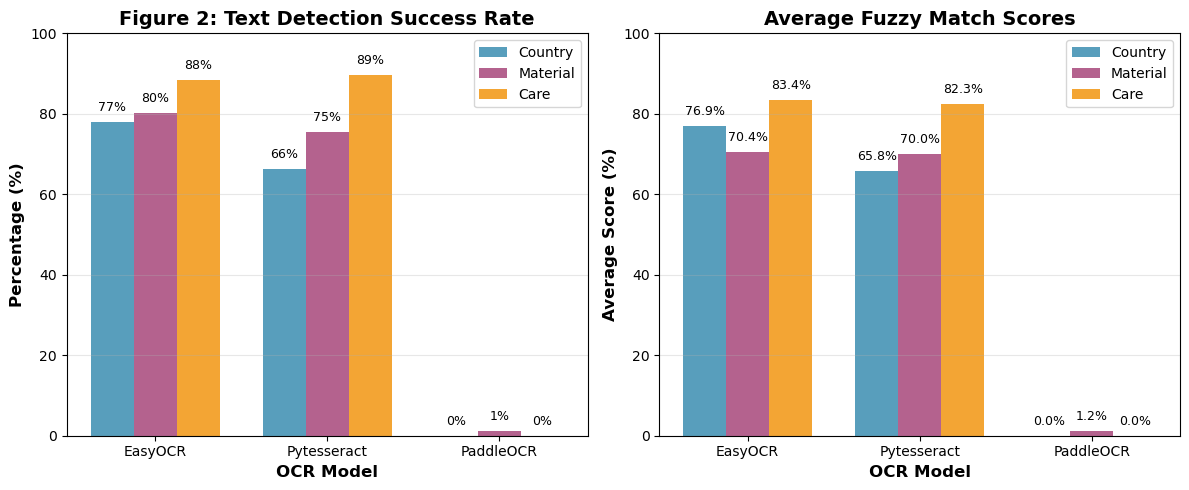


OVERALL PERFORMANCE SUMMARY

EasyOCR:
  Average Success Rate (>0.5): 82.2%
  Average Fuzzy Score: 76.9%

Pytesseract:
  Average Success Rate (>0.5): 77.1%
  Average Fuzzy Score: 72.7%

PaddleOCR:
  Average Success Rate (>0.5): 0.4%
  Average Fuzzy Score: 0.4%


In [18]:
# Create comparison dataframe
comparison_data = []

for df_name, df in [('EasyOCR', easy), ('Pytesseract', pytess), ('PaddleOCR', paddle)]:
    # Country
    country_above = (df['country_fuzzy'] > 0.5).sum()
    country_total = df['country_fuzzy'].notna().sum()
    country_pct = (country_above / country_total * 100) if country_total > 0 else 0
    
    # Material
    material_above = (df['material_fuzzy'] > 0.5).sum()
    material_total = df['material_fuzzy'].notna().sum()
    material_pct = (material_above / material_total * 100) if material_total > 0 else 0
    
    # Care
    care_above = (df['care_fuzzy'] > 0.5).sum()
    care_total = df['care_fuzzy'].notna().sum()
    care_pct = (care_above / care_total * 100) if care_total > 0 else 0
    
    # Average fuzzy scores
    country_avg = df['country_fuzzy'].mean() * 100
    material_avg = df['material_fuzzy'].mean() * 100
    care_avg = df['care_fuzzy'].mean() * 100
    
    comparison_data.append({
        'Model': df_name,
        'Country (>0.5)': country_pct,
        'Material (>0.5)': material_pct,
        'Care (>0.5)': care_pct,
        'Country Avg': country_avg,
        'Material Avg': material_avg,
        'Care Avg': care_avg
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("MODEL COMPARISON - Fuzzy Match Performance")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Percentage above 0.5 threshold
x = np.arange(len(comparison_df))
width = 0.25

ax1 = axes[0]
ax1.bar(x - width, comparison_df['Country (>0.5)'], width, label='Country', color='#2E86AB', alpha=0.8)
ax1.bar(x, comparison_df['Material (>0.5)'], width, label='Material', color='#A23B72', alpha=0.8)
ax1.bar(x + width, comparison_df['Care (>0.5)'], width, label='Care', color='#F18F01', alpha=0.8)

ax1.set_xlabel('OCR Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax1.set_title('Figure 2: Text Detection Success Rate', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Model'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 100)

# Add value labels on bars
for i, model in enumerate(comparison_df['Model']):
    ax1.text(i - width, comparison_df.loc[i, 'Country (>0.5)'] + 2, 
             f"{int(comparison_df.loc[i, 'Country (>0.5)'])}%", 
             ha='center', va='bottom', fontsize=9)
    ax1.text(i, comparison_df.loc[i, 'Material (>0.5)'] + 2, 
             f"{int(comparison_df.loc[i, 'Material (>0.5)'])}%", 
             ha='center', va='bottom', fontsize=9)
    ax1.text(i + width, comparison_df.loc[i, 'Care (>0.5)'] + 2, 
             f"{int(comparison_df.loc[i, 'Care (>0.5)'])}%", 
             ha='center', va='bottom', fontsize=9)

# Plot 2: Average fuzzy scores
ax2 = axes[1]
ax2.bar(x - width, comparison_df['Country Avg'], width, label='Country', color='#2E86AB', alpha=0.8)
ax2.bar(x, comparison_df['Material Avg'], width, label='Material', color='#A23B72', alpha=0.8)
ax2.bar(x + width, comparison_df['Care Avg'], width, label='Care', color='#F18F01', alpha=0.8)

ax2.set_xlabel('OCR Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Score (%)', fontsize=12, fontweight='bold')
ax2.set_title('Average Fuzzy Match Scores', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_df['Model'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 100)

# Add value labels on bars
for i, model in enumerate(comparison_df['Model']):
    ax2.text(i - width, comparison_df.loc[i, 'Country Avg'] + 2, 
             f"{comparison_df.loc[i, 'Country Avg']:.1f}%", 
             ha='center', va='bottom', fontsize=9)
    ax2.text(i, comparison_df.loc[i, 'Material Avg'] + 2, 
             f"{comparison_df.loc[i, 'Material Avg']:.1f}%", 
             ha='center', va='bottom', fontsize=9)
    ax2.text(i + width, comparison_df.loc[i, 'Care Avg'] + 2, 
             f"{comparison_df.loc[i, 'Care Avg']:.1f}%", 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../ocr_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("OVERALL PERFORMANCE SUMMARY")
print("="*80)
for _, row in comparison_df.iterrows():
    overall_success = (row['Country (>0.5)'] + row['Material (>0.5)'] + row['Care (>0.5)']) / 3
    overall_avg = (row['Country Avg'] + row['Material Avg'] + row['Care Avg']) / 3
    print(f"\n{row['Model']}:")
    print(f"  Average Success Rate (>0.5): {overall_success:.1f}%")
    print(f"  Average Fuzzy Score: {overall_avg:.1f}%")


In [7]:
# visualize_easyocr_boxes
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import easyocr

def draw_easyocr_boxes(image_path, output_path=None):
    """Draw EasyOCR bounding boxes on image"""
    
    print(f"\n{'='*60}")
    print(f"VISUALIZING EASYOCR BOUNDING BOXES")
    print(f"{'='*60}")
    print(f"Image: {Path(image_path).name}")
    print(f"Loading EasyOCR...")
    
    # Load image
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"✗ Could not load image: {image_path}")
        return None
    
    img_display = img.copy()
    
    # Initialize EasyOCR
    reader = easyocr.Reader(['en'], gpu=False)
    print("✓ EasyOCR loaded")
    
    # Run OCR
    print("Running OCR...")
    result = reader.readtext(img)
    
    print(f"✓ Detected {len(result)} text regions\n")
    
    # Draw boxes and print detected text
    for i, (bbox, text, conf) in enumerate(result, 1):
        # Convert bbox to integer points
        points = np.array(bbox, dtype=np.int32)
        
        # Draw rectangle
        cv2.polylines(img_display, [points], True, (0, 255, 0), 3)
        
        # Add text label above box
        x, y = int(bbox[0][0]), int(bbox[0][1])
        
        # Draw background for text label
        label = f"{text[:30]}"
        (label_width, label_height), baseline = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2
        )
        cv2.rectangle(img_display, 
                     (x, y - label_height - 10), 
                     (x + label_width, y - 5),
                     (0, 255, 0), -1)
        
        # Draw text
        cv2.putText(img_display, label, (x, y - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        
        # Add detection number
        cv2.putText(img_display, str(i), (x-20, y), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        
        # Print detection info
        print(f"  [{i}] '{text}' (confidence: {conf:.3f})")
    
    # Determine output path
    if output_path is None:
        output_folder = Path('easyocr_visualizations')
        output_folder.mkdir(exist_ok=True)
        image_name = Path(image_path).stem
        output_path = output_folder / f"{image_name}_easyocr_boxes.png"
    
    # Save
    cv2.imwrite(str(output_path), img_display)
    
    print(f"\n{'='*60}")
    print("COMPLETE")
    print(f"{'='*60}")
    print(f"✓ Saved: {output_path}")
    print(f"✓ Total detections: {len(result)}")
    
    return img_display, result

def visualize_multiple_images(image_folder='cropped_tags', num_samples=3):
    """Visualize EasyOCR boxes for multiple sample images"""
    
    folder = Path(image_folder)
    images = list(folder.glob('*.JPG')) + list(folder.glob('*.jpg'))
    
    if not images:
        print(f"No images found in {folder}")
        return
    
    # Take sample
    images = images[:num_samples]
    
    print(f"\nProcessing {len(images)} sample images...")
    print(f"{'='*60}\n")
    
    results = []
    for img_path in images:
        img_display, result = draw_easyocr_boxes(img_path)
        results.append((img_path.name, img_display, result))
        print("\n")
    
    return results

def display_with_matplotlib(image_path):
    """Display the visualization using matplotlib"""
    
    img_display, result = draw_easyocr_boxes(image_path)
    
    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
    
    # Display
    plt.figure(figsize=(15, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f'EasyOCR Detections: {Path(image_path).name}\n{len(result)} text regions detected', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save with matplotlib (higher quality)
    output_path = f'easyocr_visualizations/{Path(image_path).stem}_matplotlib.png'
    plt.savefig(output_path, dpi=200, bbox_inches='tight')
    print(f"\n✓ High-res version saved: {output_path}")
    
    plt.show()

def compare_original_vs_cropped(original_path, cropped_path):
    """Compare EasyOCR detections on original vs cropped image"""
    
    print("\n" + "="*60)
    print("COMPARING ORIGINAL VS CROPPED")
    print("="*60)
    
    # Process original
    print("\nProcessing ORIGINAL image...")
    orig_display, orig_result = draw_easyocr_boxes(
        original_path, 
        'easyocr_visualizations/original_boxes.png'
    )
    
    # Process cropped
    print("\nProcessing CROPPED image...")
    crop_display, crop_result = draw_easyocr_boxes(
        cropped_path,
        'easyocr_visualizations/cropped_boxes.png'
    )
    
    # Create side-by-side comparison
    print("\nCreating comparison...")
    
    # Resize to same height
    height = 800
    def resize_to_height(img, target_height):
        h, w = img.shape[:2]
        scale = target_height / h
        new_w = int(w * scale)
        return cv2.resize(img, (new_w, target_height))
    
    orig_resized = resize_to_height(orig_display, height)
    crop_resized = resize_to_height(crop_display, height)
    
    # Add labels
    cv2.putText(orig_resized, f"ORIGINAL ({len(orig_result)} detections)", 
               (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)
    cv2.putText(orig_resized, f"ORIGINAL ({len(orig_result)} detections)", 
               (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
    
    cv2.putText(crop_resized, f"CROPPED ({len(crop_result)} detections)", 
               (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)
    cv2.putText(crop_resized, f"CROPPED ({len(crop_result)} detections)", 
               (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
    
    # Stack horizontally
    comparison = np.hstack([orig_resized, crop_resized])
    
    comparison_path = 'easyocr_visualizations/original_vs_cropped.png'
    cv2.imwrite(comparison_path, comparison)
    
    print(f"\n{'='*60}")
    print("COMPARISON COMPLETE")
    print(f"{'='*60}")
    print(f"✓ Saved: {comparison_path}")
    print(f"\nDetection count:")
    print(f"  Original: {len(orig_result)} regions")
    print(f"  Cropped:  {len(crop_result)} regions")
    print(f"  Change:   {len(crop_result) - len(orig_result):+d}")

# ============================================================================
# USAGE
# ============================================================================

if __name__ == "__main__":
    # Option 1: Visualize a single image
    draw_easyocr_boxes('../cropped_tags/IMG_8604.JPG')
    # alternative image: 8604

    # Option 2: Visualize and display with matplotlib
    # display_with_matplotlib('../cropped_tags/IMG_8567.JPG')
    
    # Option 3: Visualize multiple samples
    # visualize_multiple_images('../cropped_tags', num_samples=5)
    
    # Option 4: Compare original vs cropped
    # compare_original_vs_cropped(
    #     '../tag_images/IMG_8567.JPG',
    #     '../cropped_tags/IMG_8567.JPG'
    # )

[2025-12-01 22:17:48,809] [ WARNING] easyocr.py:71 - Using CPU. Note: This module is much faster with a GPU.



VISUALIZING EASYOCR BOUNDING BOXES
Image: IMG_8604.JPG
Loading EasyOCR...
✓ EasyOCR loaded
Running OCR...
✓ EasyOCR loaded
Running OCR...
✓ Detected 12 text regions

  [1] 'MADE IN CHINA' (confidence: 0.939)
  [2] '73% ACRYLIC' (confidence: 0.995)
  [3] '24% POLYESTER' (confidence: 0.605)
  [4] '3% SPANDEX' (confidence: 0.999)
  [5] 'HAND WASH COLD' (confidence: 0.758)
  [6] 'SEPARATELY' (confidence: 1.000)
  [7] 'USE ONLY NON-CHLORINE' (confidence: 0.741)
  [8] 'BLEACH IF NEEDED' (confidence: 0.864)
  [9] 'RESHAPE AND' (confidence: 0.965)
  [10] 'LAY FLATTO DRY' (confidence: 0.967)
  [11] 'USE LOW IRON' (confidence: 0.671)
  [12] 'IF NECESSARY' (confidence: 0.855)

COMPLETE
✓ Saved: easyocr_visualizations/IMG_8604_easyocr_boxes.png
✓ Total detections: 12
✓ Detected 12 text regions

  [1] 'MADE IN CHINA' (confidence: 0.939)
  [2] '73% ACRYLIC' (confidence: 0.995)
  [3] '24% POLYESTER' (confidence: 0.605)
  [4] '3% SPANDEX' (confidence: 0.999)
  [5] 'HAND WASH COLD' (confidence: 0.758)

GROUND TRUTH DATA ANALYSIS

OVERALL COUNTS:
Total images in dataset: 86

COUNTRY:
  Non-blank: 45 (52.3%)
  Blank/Missing: 41 (47.7%)
  Distinct values: 14

MATERIAL:
  Non-blank: 66 (76.7%)
  Blank/Missing: 20 (23.3%)
  Distinct values: 53

CARE:
  Non-blank: 52 (60.5%)
  Blank/Missing: 34 (39.5%)
  Distinct values: 47

SAMPLE DISTINCT VALUES

COUNTRY (showing up to 10):
  1. Bangladesh
  2. Cambodia
  3. Canada
  4. China
  5. Guatemala
  6. India
  7. Nicaragua
  8. Peru
  9. Philippines
  10. Turkey
  ... and 4 more

MATERIAL (showing up to 10):
  1. 100% Cashmere
  2. 100% Cotton
  3. 100% Cotton, 100% Polyester
  4. 100% Merino Extra Fine Wool
  5. 100% Organic Cotton
  6. 100% Polyester
  7. 100% cotton
  8. 100% nylon, 100% recycled polyester
  9. 48% Viscose, 31% Polyester, 18% Nylon, 3% Elastane
  10. 49% Rayon, 31% Polyester, 20% Nylon
  ... and 43 more

CARE (showing up to 10):
  1. Dry clean only
  2. Dry clean or hand wash cold, do not twist or wring, do not bleach, resha

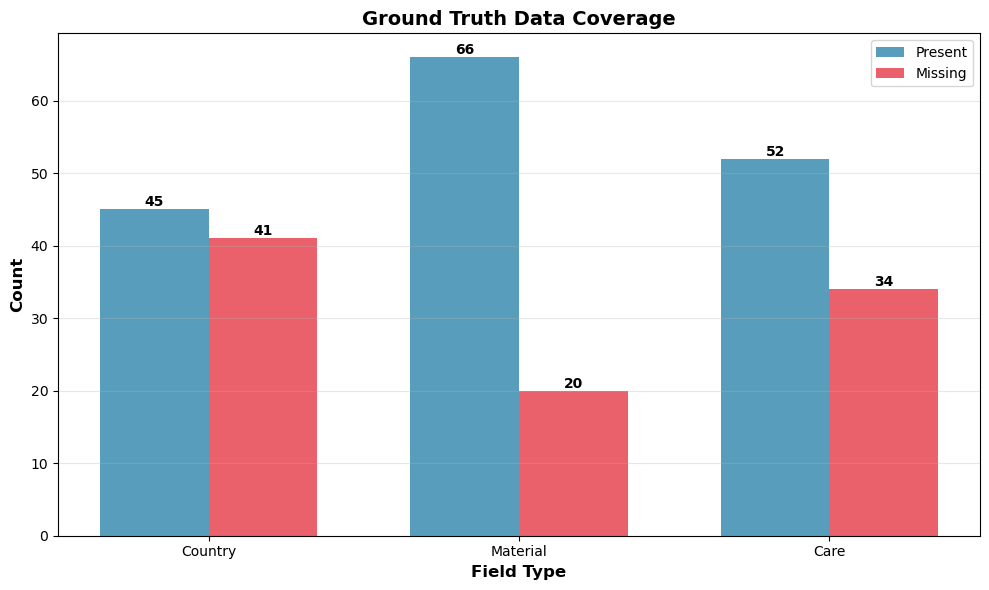


✓ Visualization saved to: ground_truth_coverage.png


In [10]:
# Analyze ground truth data (using EasyOCR dataset as reference since all should have same ground truth)
print("="*80)
print("GROUND TRUTH DATA ANALYSIS")
print("="*80)

# Count non-blank values (not NaN, not None, not empty string)
def count_non_blank(series):
    return series.notna().sum() - (series == '').sum()

# Count distinct values
def count_distinct(series):
    return series[series.notna() & (series != '')].nunique()

print("\nOVERALL COUNTS:")
print(f"Total images in dataset: {len(easy)}")

for field in ['country', 'material', 'care']:
    col_name = f'{field}_true'
    
    non_blank = count_non_blank(easy[col_name])
    distinct = count_distinct(easy[col_name])
    blank = len(easy) - non_blank
    pct_non_blank = (non_blank / len(easy)) * 100
    
    print(f"\n{field.upper()}:")
    print(f"  Non-blank: {non_blank} ({pct_non_blank:.1f}%)")
    print(f"  Blank/Missing: {blank} ({100-pct_non_blank:.1f}%)")
    print(f"  Distinct values: {distinct}")

# Show sample of distinct values for each field
print("\n" + "="*80)
print("SAMPLE DISTINCT VALUES")
print("="*80)

for field in ['country', 'material', 'care']:
    col_name = f'{field}_true'
    distinct_values = easy[col_name][easy[col_name].notna() & (easy[col_name] != '')].unique()
    
    print(f"\n{field.upper()} (showing up to 10):")
    for i, value in enumerate(sorted(distinct_values)[:10], 1):
        # Truncate long values (like care instructions)
        display_value = str(value)[:100]
        if len(str(value)) > 100:
            display_value += "..."
        print(f"  {i}. {display_value}")
    
    if len(distinct_values) > 10:
        print(f"  ... and {len(distinct_values) - 10} more")

# Create visualization of data coverage
fig, ax = plt.subplots(figsize=(10, 6))

fields = ['Country', 'Material', 'Care']
non_blank_counts = [
    count_non_blank(easy['country_true']),
    count_non_blank(easy['material_true']),
    count_non_blank(easy['care_true'])
]
blank_counts = [
    len(easy) - count_non_blank(easy['country_true']),
    len(easy) - count_non_blank(easy['material_true']),
    len(easy) - count_non_blank(easy['care_true'])
]

x = np.arange(len(fields))
width = 0.35

bars1 = ax.bar(x - width/2, non_blank_counts, width, label='Present', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x + width/2, blank_counts, width, label='Missing', color='#E63946', alpha=0.8)

ax.set_xlabel('Field Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Ground Truth Data Coverage', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(fields)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../ground_truth_coverage.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to: ground_truth_coverage.png")


In [11]:
# Get all distinct materials from the ground truth data

# Get all non-blank material values
materials = easy['material_true'][easy['material_true'].notna() & (easy['material_true'] != '')].unique()

print(f"\nTotal distinct material combinations: {len(materials)}")
print(f"\nAll materials found:\n")

# Sort and display all materials
for i, material in enumerate(sorted(materials), 1):
    print(f"{i:3d}. {material}")

# Extract individual fiber types from material compositions
print("\n" + "="*80)
print("INDIVIDUAL FIBER TYPES")
print("="*80)

fiber_types = set()
for material in materials:
    # Split by common delimiters and extract fiber names
    parts = str(material).split()
    for part in parts:
        # Remove percentages and extract just the fiber name
        if '%' not in part and part.isalpha():
            fiber_types.add(part.upper())

print(f"\nUnique fiber types found: {len(fiber_types)}")
print(f"\n{', '.join(sorted(fiber_types))}")

# Count frequency of each material combination
print("\n" + "="*80)
print("MATERIAL FREQUENCY")
print("="*80)

material_counts = easy['material_true'][easy['material_true'].notna() & (easy['material_true'] != '')].value_counts()

print(f"\nTop 10 most common material combinations:\n")
for i, (material, count) in enumerate(material_counts.head(10).items(), 1):
    pct = (count / len(easy)) * 100
    print(f"{i:2d}. {material:<50} - {count:3d} images ({pct:.1f}%)")

if len(material_counts) > 10:
    print(f"\n... and {len(material_counts) - 10} other material combinations")

# # Export to CSV for reference
# material_list_df = pd.DataFrame({
#     'Material': sorted(materials),
#     'Count': [material_counts.get(m, 0) for m in sorted(materials)]
# })
# material_list_df.to_csv('../distinct_materials.csv', index=False)
# print(f"\n✓ Full material list exported to: distinct_materials.csv")



Total distinct material combinations: 53

All materials found:

  1. 100% Cashmere
  2. 100% Cotton
  3. 100% Cotton, 100% Polyester
  4. 100% Merino Extra Fine Wool
  5. 100% Organic Cotton
  6. 100% Polyester
  7. 100% cotton
  8. 100% nylon, 100% recycled polyester
  9. 48% Viscose, 31% Polyester, 18% Nylon, 3% Elastane
 10. 49% Rayon, 31% Polyester, 20% Nylon
 11. 50% Merino Wool, 50% Acrylic
 12. 50% MicoModal, 50% Suprima Cotton
 13. 50% Modal, 50% Cotton
 14. 50% Pima Cotton, 50% Modal
 15. 51% Rayon, 28% Polyester, 21% Nylon
 16. 52% Modal, 24% Polyester, 24% Cotton
 17. 52% Viscose, 36% Nylon, 12% Polyester
 18. 52% viscose, 28% polyester, 20% nylon
 19. 53% Cotton, 47% Polyester, 49% Cotton, 49% Polyester, 2% Spandex
 20. 55% Merino Wool, 25% Recycled Nylon, 20% Cotton
 21. 55% cotton, 45% viscose
 22. 55% viscose, 45% nylon
 23. 57% Viscose, 43% Polyester
 24. 58% Rayon, 24% Polyester, 13% Metallic, 5% Elastane
 25. 60% Cotton, 40% Acrylic
 26. 60% Cotton, 40% Polyester
 27

DISTINCT COUNTRIES IN DATASET

Total distinct countries: 14

All countries found:

  1. Bangladesh
  2. Cambodia
  3. Canada
  4. China
  5. Guatemala
  6. India
  7. Nicaragua
  8. Peru
  9. Philippines
 10. Turkey
 11. USA
 12. Vietnam
 13. cambodia
 14. made in Vietnam

COUNTRY FREQUENCY

All countries by frequency:

 1. China                          -  19 images (22.1%)
 2. Vietnam                        -   4 images (4.7%)
 3. cambodia                       -   3 images (3.5%)
 4. Guatemala                      -   3 images (3.5%)
 5. Cambodia                       -   3 images (3.5%)
 6. USA                            -   3 images (3.5%)
 7. India                          -   2 images (2.3%)
 8. Peru                           -   2 images (2.3%)
 9. Nicaragua                      -   1 images (1.2%)
10. Bangladesh                     -   1 images (1.2%)
11. made in Vietnam                -   1 images (1.2%)
12. Turkey                         -   1 images (1.2%)
13. Canada       

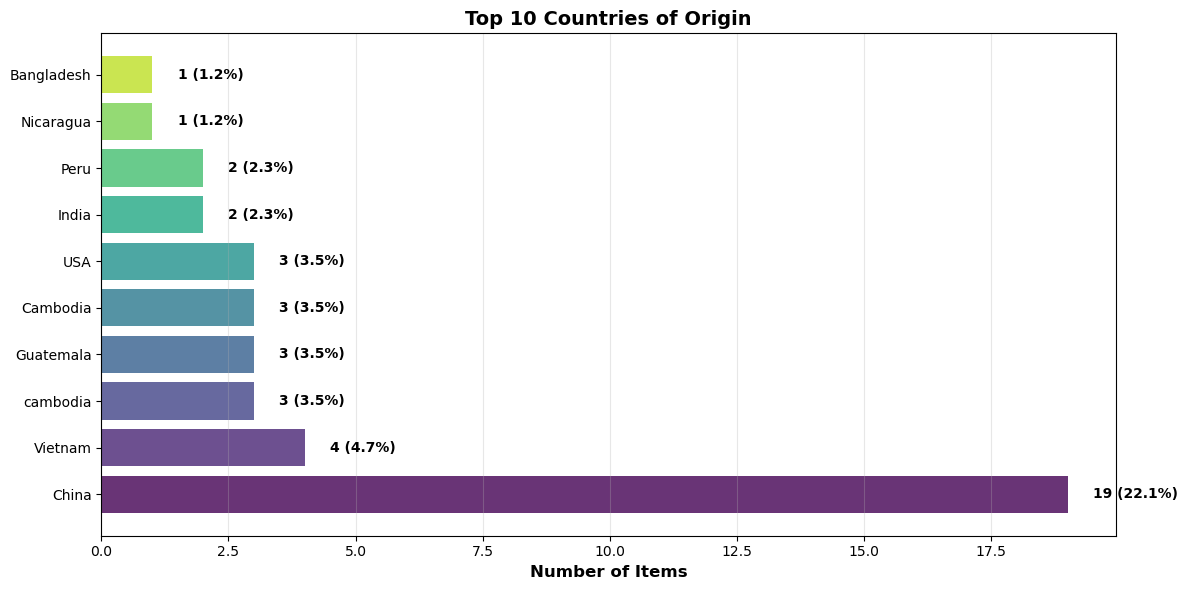


✓ Visualization saved to: country_distribution.png


In [13]:
# Get all distinct countries from the ground truth data
print("="*80)
print("DISTINCT COUNTRIES IN DATASET")
print("="*80)

# Get all non-blank country values
countries = easy['country_true'][easy['country_true'].notna() & (easy['country_true'] != '')].unique()

print(f"\nTotal distinct countries: {len(countries)}")
print(f"\nAll countries found:\n")

# Sort and display all countries
for i, country in enumerate(sorted(countries), 1):
    print(f"{i:3d}. {country}")

# Count frequency of each country
print("\n" + "="*80)
print("COUNTRY FREQUENCY")
print("="*80)

country_counts = easy['country_true'][easy['country_true'].notna() & (easy['country_true'] != '')].value_counts()

print(f"\nAll countries by frequency:\n")
for i, (country, count) in enumerate(country_counts.items(), 1):
    pct = (count / len(easy)) * 100
    print(f"{i:2d}. {country:<30} - {count:3d} images ({pct:.1f}%)")

# Create visualization of top countries
fig, ax = plt.subplots(figsize=(12, 6))

top_countries = country_counts.head(10)
colors = plt.cm.viridis(np.linspace(0, 0.9, len(top_countries)))

bars = ax.barh(range(len(top_countries)), top_countries.values, color=colors, alpha=0.8)
ax.set_yticks(range(len(top_countries)))
ax.set_yticklabels(top_countries.index)
ax.set_xlabel('Number of Items', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Countries of Origin', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (country, count) in enumerate(top_countries.items()):
    pct = (count / len(easy)) * 100
    ax.text(count + 0.5, i, f'{count} ({pct:.1f}%)', 
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../country_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: country_distribution.png")


DISTINCT CARE INSTRUCTIONS IN DATASET

Total distinct care instruction combinations: 47

All care instructions found:

  1. Dry clean only
  2. Dry clean or hand wash cold, do not twist or wring, do not bleach, reshape and lay flat to dry, warm iron if needed
  3. Hand wash cold separately, non-chlorine bleach only, reshape and lay flat to dry, iron on lowest setting
  4. Hand wash cold, do not bleach, reshape while damp, dry flat, cool iron only if needed, or dry clean
  5. Machine wash cold gentle cycle, close all fasteners before washing, wash in mesh bag, use mild detergent, wash separatel...
  6. Machine wash cold with like colors with mild detergent, only non-chlorine bleach when needed, tumble dry low remove prom...
  7. Machine wash cold with like colors, non-chlorine bleach only, tumble dry low, iron on lowest setting
  8. Machine wash cold with like colors, tumble dry low, do not bleach
  9. Machine wash cold with like colours, do not bleach, dry flat, cool iron only if neede

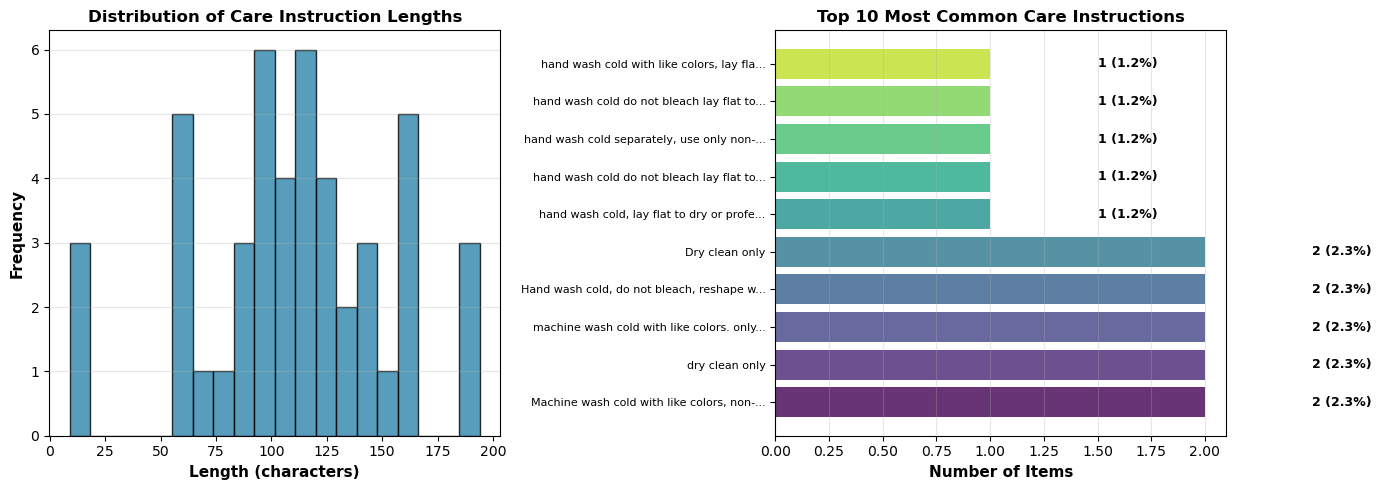


✓ Visualization saved to: care_instructions_analysis.png


In [14]:
# Get all distinct care instructions from the ground truth data
print("="*80)
print("DISTINCT CARE INSTRUCTIONS IN DATASET")
print("="*80)

# Get all non-blank care values
care_instructions = easy['care_true'][easy['care_true'].notna() & (easy['care_true'] != '')].unique()

print(f"\nTotal distinct care instruction combinations: {len(care_instructions)}")
print(f"\nAll care instructions found:\n")

# Sort and display all care instructions (truncated for readability)
for i, care in enumerate(sorted(care_instructions), 1):
    # Truncate very long care instructions
    display_care = str(care)[:120]
    if len(str(care)) > 120:
        display_care += "..."
    print(f"{i:3d}. {display_care}")

# Count frequency of each care instruction
print("\n" + "="*80)
print("CARE INSTRUCTION FREQUENCY")
print("="*80)

care_counts = easy['care_true'][easy['care_true'].notna() & (easy['care_true'] != '')].value_counts()

print(f"\nTop 15 most common care instructions:\n")
for i, (care, count) in enumerate(care_counts.head(15).items(), 1):
    pct = (count / len(easy)) * 100
    # Truncate for display
    display_care = str(care)[:80]
    if len(str(care)) > 80:
        display_care += "..."
    print(f"{i:2d}. [{count:3d} images, {pct:.1f}%]")
    print(f"    {display_care}\n")

if len(care_counts) > 15:
    print(f"... and {len(care_counts) - 15} other care instruction combinations")

# Extract common care keywords
print("\n" + "="*80)
print("COMMON CARE KEYWORDS")
print("="*80)

care_keywords = {}
for care in care_instructions:
    # Convert to uppercase and split
    words = str(care).upper().split()
    for word in words:
        # Clean up word (remove punctuation)
        clean_word = ''.join(c for c in word if c.isalpha())
        if len(clean_word) > 3:  # Only words longer than 3 chars
            care_keywords[clean_word] = care_keywords.get(clean_word, 0) + 1

# Sort by frequency
sorted_keywords = sorted(care_keywords.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop 20 most common keywords in care instructions:\n")
for i, (keyword, count) in enumerate(sorted_keywords[:20], 1):
    print(f"{i:2d}. {keyword:<20} - appears in {count} instructions")

# Visualize care instruction length distribution
care_lengths = [len(str(care)) for care in care_instructions]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of care instruction lengths
ax1 = axes[0]
ax1.hist(care_lengths, bins=20, color='#2E86AB', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Length (characters)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Care Instruction Lengths', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Top care instructions frequency
ax2 = axes[1]
top_care = care_counts.head(10)
colors = plt.cm.viridis(np.linspace(0, 0.9, len(top_care)))

# Create short labels for the bar chart
labels = [str(care)[:40] + '...' if len(str(care)) > 40 else str(care) for care in top_care.index]

bars = ax2.barh(range(len(top_care)), top_care.values, color=colors, alpha=0.8)
ax2.set_yticks(range(len(top_care)))
ax2.set_yticklabels(labels, fontsize=8)
ax2.set_xlabel('Number of Items', fontsize=11, fontweight='bold')
ax2.set_title('Top 10 Most Common Care Instructions', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, count in enumerate(top_care.values):
    pct = (count / len(easy)) * 100
    ax2.text(count + 0.5, i, f'{count} ({pct:.1f}%)', 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../care_instructions_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: care_instructions_analysis.png")


In [19]:
# Analyze common characteristics among clothing items with high CO2 emissions

# Load the emissions data
emissions_df = pd.read_csv('../emissions_estimates_from_ocr.csv')

print("="*80)
print("HIGH CO2 EMISSIONS ANALYSIS")
print("="*80)

# Filter out rows with missing emissions data
valid_emissions = emissions_df[emissions_df['total_kgco2e'].notna()].copy()

print(f"\nTotal items with valid emissions: {len(valid_emissions)}")
print(f"\nEmissions statistics:")
print(f"  Mean:   {valid_emissions['total_kgco2e'].mean():.3f} kg CO2e")
print(f"  Median: {valid_emissions['total_kgco2e'].median():.3f} kg CO2e")
print(f"  Min:    {valid_emissions['total_kgco2e'].min():.3f} kg CO2e")
print(f"  Max:    {valid_emissions['total_kgco2e'].max():.3f} kg CO2e")
print(f"  Std:    {valid_emissions['total_kgco2e'].std():.3f} kg CO2e")

# Define high emissions threshold (top 25% or top quartile)
high_threshold = valid_emissions['total_kgco2e'].quantile(0.75)
print(f"\nHigh emissions threshold (75th percentile): {high_threshold:.3f} kg CO2e")

# Separate high and low emissions items
high_co2 = valid_emissions[valid_emissions['total_kgco2e'] >= high_threshold].copy()
low_co2 = valid_emissions[valid_emissions['total_kgco2e'] < high_threshold].copy()

print(f"\nHigh CO2 items (>= {high_threshold:.3f}): {len(high_co2)}")
print(f"Low CO2 items (< {high_threshold:.3f}): {len(low_co2)}")

# ============================================================================
# COUNTRY ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("COUNTRY ANALYSIS")
print("="*80)

def get_country_stats(df, label):
    # Count non-blank countries
    countries = df['country_pred'][df['country_pred'].notna() & (df['country_pred'] != '') & (df['country_pred'] != 'not visible')]
    country_counts = countries.value_counts()
    
    print(f"\n{label} (n={len(df)}):")
    print(f"  Items with country data: {len(countries)} ({len(countries)/len(df)*100:.1f}%)")
    
    if len(country_counts) > 0:
        print(f"\n  Top 5 countries:")
        for i, (country, count) in enumerate(country_counts.head(5).items(), 1):
            pct = (count / len(countries)) * 100
            avg_emissions = df[df['country_pred'] == country]['total_kgco2e'].mean()
            print(f"    {i}. {country:<20} - {count:3d} items ({pct:.1f}%) | Avg: {avg_emissions:.3f} kg CO2e")
    
    return country_counts

high_countries = get_country_stats(high_co2, "HIGH CO2 ITEMS")
low_countries = get_country_stats(low_co2, "LOW CO2 ITEMS")

# ============================================================================
# MATERIAL ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("MATERIAL ANALYSIS")
print("="*80)

def get_material_stats(df, label):
    # Count non-blank materials
    materials = df['material_pred'][df['material_pred'].notna() & (df['material_pred'] != '') & (df['material_pred'] != 'not visible')]
    material_counts = materials.value_counts()
    
    print(f"\n{label} (n={len(df)}):")
    print(f"  Items with material data: {len(materials)} ({len(materials)/len(df)*100:.1f}%)")
    
    if len(material_counts) > 0:
        print(f"\n  Top 5 materials:")
        for i, (material, count) in enumerate(material_counts.head(5).items(), 1):
            pct = (count / len(materials)) * 100
            avg_emissions = df[df['material_pred'] == material]['total_kgco2e'].mean()
            print(f"    {i}. {material:<40} - {count:3d} items ({pct:.1f}%) | Avg: {avg_emissions:.3f} kg CO2e")
    
    return material_counts

high_materials = get_material_stats(high_co2, "HIGH CO2 ITEMS")
low_materials = get_material_stats(low_co2, "LOW CO2 ITEMS")

# ============================================================================
# CARE INSTRUCTION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("CARE INSTRUCTION ANALYSIS")
print("="*80)

def extract_care_keywords(df):
    """Extract and count care instruction keywords"""
    keywords = {}
    
    for care in df['care_pred']:
        if pd.notna(care) and care != '' and care != 'not visible':
            # Extract common care terms
            care_lower = str(care).lower()
            
            # Washing
            if 'machine wash' in care_lower or 'wash' in care_lower:
                if 'cold' in care_lower:
                    keywords['machine_wash_cold'] = keywords.get('machine_wash_cold', 0) + 1
                elif 'warm' in care_lower:
                    keywords['machine_wash_warm'] = keywords.get('machine_wash_warm', 0) + 1
                elif 'hot' in care_lower:
                    keywords['machine_wash_hot'] = keywords.get('machine_wash_hot', 0) + 1
                else:
                    keywords['machine_wash'] = keywords.get('machine_wash', 0) + 1
            
            # Drying
            if 'tumble dry' in care_lower:
                if 'low' in care_lower:
                    keywords['tumble_dry_low'] = keywords.get('tumble_dry_low', 0) + 1
                elif 'medium' in care_lower:
                    keywords['tumble_dry_medium'] = keywords.get('tumble_dry_medium', 0) + 1
                elif 'high' in care_lower:
                    keywords['tumble_dry_high'] = keywords.get('tumble_dry_high', 0) + 1
                else:
                    keywords['tumble_dry'] = keywords.get('tumble_dry', 0) + 1
            
            if 'line dry' in care_lower or 'hang dry' in care_lower:
                keywords['air_dry'] = keywords.get('air_dry', 0) + 1
            
            # Dry clean
            if 'dry clean' in care_lower:
                keywords['dry_clean'] = keywords.get('dry_clean', 0) + 1
            
            # Bleach
            if 'bleach' in care_lower:
                if 'no bleach' in care_lower or 'do not bleach' in care_lower:
                    keywords['no_bleach'] = keywords.get('no_bleach', 0) + 1
                else:
                    keywords['bleach'] = keywords.get('bleach', 0) + 1
    
    return keywords

high_care = extract_care_keywords(high_co2)
low_care = extract_care_keywords(low_co2)

print(f"\nHIGH CO2 ITEMS - Care instruction keywords:")
for keyword, count in sorted(high_care.items(), key=lambda x: x[1], reverse=True):
    pct = (count / len(high_co2)) * 100
    print(f"  {keyword:<25} - {count:3d} items ({pct:.1f}%)")

print(f"\nLOW CO2 ITEMS - Care instruction keywords:")
for keyword, count in sorted(low_care.items(), key=lambda x: x[1], reverse=True):
    pct = (count / len(low_co2)) * 100
    print(f"  {keyword:<25} - {count:3d} items ({pct:.1f}%)")

# ============================================================================
# EMISSIONS BREAKDOWN ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("EMISSIONS BREAKDOWN COMPARISON")
print("="*80)

def print_breakdown(df, label):
    print(f"\n{label}:")
    print(f"  Total:        {df['total_kgco2e'].mean():.3f} ± {df['total_kgco2e'].std():.3f} kg CO2e")
    print(f"  Materials:    {df['materials_kgco2e'].mean():.3f} ± {df['materials_kgco2e'].std():.3f} kg CO2e ({df['materials_kgco2e'].mean()/df['total_kgco2e'].mean()*100:.1f}%)")
    print(f"  Manufacturing:{df['manufacturing_kgco2e'].mean():.3f} ± {df['manufacturing_kgco2e'].std():.3f} kg CO2e ({df['manufacturing_kgco2e'].mean()/df['total_kgco2e'].mean()*100:.1f}%)")
    print(f"  Washing:      {df['washing_kgco2e'].mean():.3f} ± {df['washing_kgco2e'].std():.3f} kg CO2e ({df['washing_kgco2e'].mean()/df['total_kgco2e'].mean()*100:.1f}%)")

print_breakdown(high_co2, "HIGH CO2 ITEMS")
print_breakdown(low_co2, "LOW CO2 ITEMS")


HIGH CO2 EMISSIONS ANALYSIS

Total items with valid emissions: 80

Emissions statistics:
  Mean:   56.187 kg CO2e
  Median: 30.816 kg CO2e
  Min:    29.150 kg CO2e
  Max:    179.300 kg CO2e
  Std:    51.199 kg CO2e

High emissions threshold (75th percentile): 37.752 kg CO2e

High CO2 items (>= 37.752): 20
Low CO2 items (< 37.752): 60

COUNTRY ANALYSIS

HIGH CO2 ITEMS (n=20):
  Items with country data: 6 (30.0%)

  Top 5 countries:
    1. Cambodia             -   2 items (33.3%) | Avg: 162.325 kg CO2e
    2. NICARAGUA            -   1 items (16.7%) | Avg: 167.000 kg CO2e
    3. UsA Ok               -   1 items (16.7%) | Avg: 154.825 kg CO2e
    4. CHINA                -   1 items (16.7%) | Avg: 158.960 kg CO2e
    5. USA                  -   1 items (16.7%) | Avg: 153.850 kg CO2e

LOW CO2 ITEMS (n=60):
  Items with country data: 24 (40.0%)

  Top 5 countries:
    1. CHINA                -   5 items (20.8%) | Avg: 30.840 kg CO2e
    2. VIETNAM              -   4 items (16.7%) | Avg: 29.4

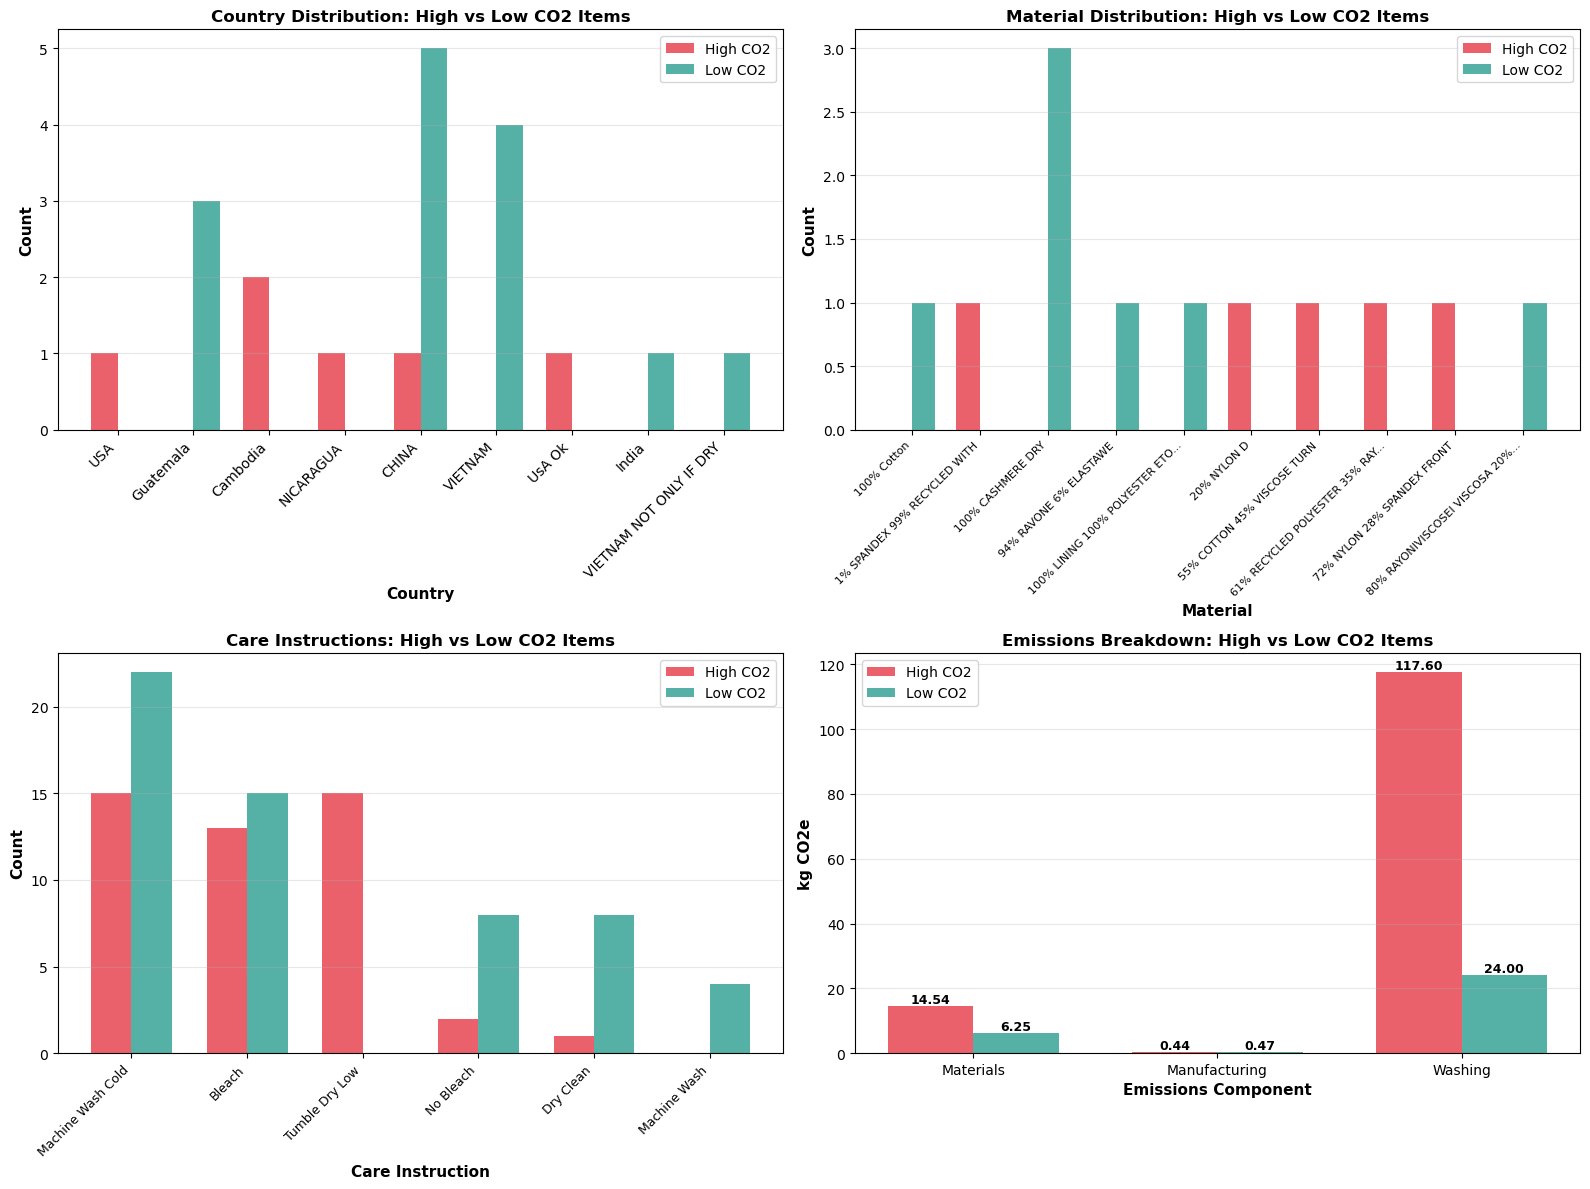


✓ Visualization saved to: high_vs_low_co2_characteristics.png


In [20]:
# Visualize high vs low CO2 characteristics

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ============================================================================
# Plot 1: Country Distribution Comparison
# ============================================================================
ax1 = axes[0, 0]

# Get top 5 countries from each group
high_top_countries = high_countries.head(5) if len(high_countries) > 0 else pd.Series()
low_top_countries = low_countries.head(5) if len(low_countries) > 0 else pd.Series()

# Combine and get unique countries
all_countries = set(high_top_countries.index) | set(low_top_countries.index)

if len(all_countries) > 0:
    x_pos = np.arange(len(all_countries))
    width = 0.35
    
    high_vals = [high_top_countries.get(c, 0) for c in all_countries]
    low_vals = [low_top_countries.get(c, 0) for c in all_countries]
    
    ax1.bar(x_pos - width/2, high_vals, width, label='High CO2', color='#E63946', alpha=0.8)
    ax1.bar(x_pos + width/2, low_vals, width, label='Low CO2', color='#2A9D8F', alpha=0.8)
    
    ax1.set_xlabel('Country', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax1.set_title('Country Distribution: High vs Low CO2 Items', fontsize=12, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(list(all_countries), rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

# ============================================================================
# Plot 2: Material Distribution Comparison
# ============================================================================
ax2 = axes[0, 1]

# Get top 5 materials from each group
high_top_materials = high_materials.head(5) if len(high_materials) > 0 else pd.Series()
low_top_materials = low_materials.head(5) if len(low_materials) > 0 else pd.Series()

# Combine and get unique materials
all_materials = set(high_top_materials.index) | set(low_top_materials.index)

if len(all_materials) > 0:
    # Create short labels
    material_labels = [str(m)[:30] + '...' if len(str(m)) > 30 else str(m) for m in all_materials]
    
    x_pos = np.arange(len(all_materials))
    width = 0.35
    
    high_vals = [high_top_materials.get(m, 0) for m in all_materials]
    low_vals = [low_top_materials.get(m, 0) for m in all_materials]
    
    ax2.bar(x_pos - width/2, high_vals, width, label='High CO2', color='#E63946', alpha=0.8)
    ax2.bar(x_pos + width/2, low_vals, width, label='Low CO2', color='#2A9D8F', alpha=0.8)
    
    ax2.set_xlabel('Material', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax2.set_title('Material Distribution: High vs Low CO2 Items', fontsize=12, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(material_labels, rotation=45, ha='right', fontsize=8)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

# ============================================================================
# Plot 3: Care Instructions Comparison
# ============================================================================
ax3 = axes[1, 0]

# Get all unique care keywords
all_care_keywords = set(high_care.keys()) | set(low_care.keys())

if len(all_care_keywords) > 0:
    # Sort by total frequency
    sorted_keywords = sorted(all_care_keywords, 
                            key=lambda x: high_care.get(x, 0) + low_care.get(x, 0), 
                            reverse=True)[:8]  # Top 8
    
    x_pos = np.arange(len(sorted_keywords))
    width = 0.35
    
    high_vals = [high_care.get(k, 0) for k in sorted_keywords]
    low_vals = [low_care.get(k, 0) for k in sorted_keywords]
    
    ax3.bar(x_pos - width/2, high_vals, width, label='High CO2', color='#E63946', alpha=0.8)
    ax3.bar(x_pos + width/2, low_vals, width, label='Low CO2', color='#2A9D8F', alpha=0.8)
    
    ax3.set_xlabel('Care Instruction', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax3.set_title('Care Instructions: High vs Low CO2 Items', fontsize=12, fontweight='bold')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([k.replace('_', ' ').title() for k in sorted_keywords], 
                        rotation=45, ha='right', fontsize=9)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

# ============================================================================
# Plot 4: Emissions Breakdown Comparison
# ============================================================================
ax4 = axes[1, 1]

categories = ['Materials', 'Manufacturing', 'Washing']
high_means = [
    high_co2['materials_kgco2e'].mean(),
    high_co2['manufacturing_kgco2e'].mean(),
    high_co2['washing_kgco2e'].mean()
]
low_means = [
    low_co2['materials_kgco2e'].mean(),
    low_co2['manufacturing_kgco2e'].mean(),
    low_co2['washing_kgco2e'].mean()
]

x_pos = np.arange(len(categories))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, high_means, width, label='High CO2', color='#E63946', alpha=0.8)
bars2 = ax4.bar(x_pos + width/2, low_means, width, label='Low CO2', color='#2A9D8F', alpha=0.8)

ax4.set_xlabel('Emissions Component', fontsize=11, fontweight='bold')
ax4.set_ylabel('kg CO2e', fontsize=11, fontweight='bold')
ax4.set_title('Emissions Breakdown: High vs Low CO2 Items', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(categories)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../high_vs_low_co2_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to: high_vs_low_co2_characteristics.png")


In [21]:
# Summary table of key characteristics

print("\n" + "="*80)
print("SUMMARY: KEY CHARACTERISTICS OF HIGH CO2 CLOTHING ITEMS")
print("="*80)

summary_data = []

# Top countries
if len(high_countries) > 0:
    top_high_country = high_countries.index[0]
    top_high_country_pct = (high_countries.iloc[0] / len(high_co2)) * 100
    summary_data.append({
        'Characteristic': 'Most Common Country',
        'High CO2 Items': f"{top_high_country} ({top_high_country_pct:.1f}%)",
        'Low CO2 Items': f"{low_countries.index[0] if len(low_countries) > 0 else 'N/A'} ({(low_countries.iloc[0] / len(low_co2)) * 100:.1f}%)" if len(low_countries) > 0 else 'N/A'
    })

# Top materials
if len(high_materials) > 0:
    top_high_material = str(high_materials.index[0])[:40]
    top_high_material_pct = (high_materials.iloc[0] / len(high_co2)) * 100
    top_low_material = str(low_materials.index[0])[:40] if len(low_materials) > 0 else 'N/A'
    summary_data.append({
        'Characteristic': 'Most Common Material',
        'High CO2 Items': f"{top_high_material} ({top_high_material_pct:.1f}%)",
        'Low CO2 Items': f"{top_low_material} ({(low_materials.iloc[0] / len(low_co2)) * 100:.1f}%)" if len(low_materials) > 0 else 'N/A'
    })

# Average emissions
summary_data.append({
    'Characteristic': 'Avg Total Emissions',
    'High CO2 Items': f"{high_co2['total_kgco2e'].mean():.3f} kg CO2e",
    'Low CO2 Items': f"{low_co2['total_kgco2e'].mean():.3f} kg CO2e"
})

summary_data.append({
    'Characteristic': 'Avg Materials Emissions',
    'High CO2 Items': f"{high_co2['materials_kgco2e'].mean():.3f} kg CO2e",
    'Low CO2 Items': f"{low_co2['materials_kgco2e'].mean():.3f} kg CO2e"
})

summary_data.append({
    'Characteristic': 'Avg Manufacturing Emissions',
    'High CO2 Items': f"{high_co2['manufacturing_kgco2e'].mean():.3f} kg CO2e",
    'Low CO2 Items': f"{low_co2['manufacturing_kgco2e'].mean():.3f} kg CO2e"
})

summary_data.append({
    'Characteristic': 'Avg Washing Emissions',
    'High CO2 Items': f"{high_co2['washing_kgco2e'].mean():.3f} kg CO2e",
    'Low CO2 Items': f"{low_co2['washing_kgco2e'].mean():.3f} kg CO2e"
})

# Most common care instructions
if len(high_care) > 0:
    top_high_care = max(high_care, key=high_care.get)
    top_high_care_pct = (high_care[top_high_care] / len(high_co2)) * 100
    top_low_care = max(low_care, key=low_care.get) if len(low_care) > 0 else 'N/A'
    summary_data.append({
        'Characteristic': 'Most Common Care',
        'High CO2 Items': f"{top_high_care.replace('_', ' ').title()} ({top_high_care_pct:.1f}%)",
        'Low CO2 Items': f"{top_low_care.replace('_', ' ').title()} ({(low_care[top_low_care] / len(low_co2)) * 100:.1f}%)" if len(low_care) > 0 else 'N/A'
    })

summary_df = pd.DataFrame(summary_data)

print("\n")
print(summary_df.to_string(index=False))

# Calculate key insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

emissions_diff = high_co2['total_kgco2e'].mean() - low_co2['total_kgco2e'].mean()
emissions_pct_diff = (emissions_diff / low_co2['total_kgco2e'].mean()) * 100

print(f"\n1. High CO2 items have {emissions_pct_diff:.1f}% higher emissions than low CO2 items")
print(f"   (Difference: {emissions_diff:.3f} kg CO2e)")

# Which component contributes most to the difference?
materials_diff = high_co2['materials_kgco2e'].mean() - low_co2['materials_kgco2e'].mean()
manufacturing_diff = high_co2['manufacturing_kgco2e'].mean() - low_co2['manufacturing_kgco2e'].mean()
washing_diff = high_co2['washing_kgco2e'].mean() - low_co2['washing_kgco2e'].mean()

total_diff = materials_diff + manufacturing_diff + washing_diff
materials_contrib = (materials_diff / total_diff) * 100 if total_diff > 0 else 0
manufacturing_contrib = (manufacturing_diff / total_diff) * 100 if total_diff > 0 else 0
washing_contrib = (washing_diff / total_diff) * 100 if total_diff > 0 else 0

print(f"\n2. Contribution to higher emissions:")
print(f"   - Materials:     {materials_contrib:.1f}% ({materials_diff:+.3f} kg CO2e)")
print(f"   - Manufacturing: {manufacturing_contrib:.1f}% ({manufacturing_diff:+.3f} kg CO2e)")
print(f"   - Washing:       {washing_contrib:.1f}% ({washing_diff:+.3f} kg CO2e)")

# Country patterns
if len(high_countries) > 0 and len(low_countries) > 0:
    print(f"\n3. Geographic patterns:")
    print(f"   - High CO2 items most commonly from: {high_countries.index[0]}")
    print(f"   - Low CO2 items most commonly from: {low_countries.index[0]}")

# Material patterns
if len(high_materials) > 0 and len(low_materials) > 0:
    print(f"\n4. Material patterns:")
    print(f"   - High CO2 items: {str(high_materials.index[0])[:60]}")
    print(f"   - Low CO2 items: {str(low_materials.index[0])[:60]}")

# Care patterns
if len(high_care) > 0 and len(low_care) > 0:
    top_high_care = max(high_care, key=high_care.get)
    top_low_care = max(low_care, key=low_care.get)
    print(f"\n5. Care instruction patterns:")
    print(f"   - High CO2 items most often require: {top_high_care.replace('_', ' ')}")
    print(f"   - Low CO2 items most often require: {top_low_care.replace('_', ' ')}")

print("\n" + "="*80)



SUMMARY: KEY CHARACTERISTICS OF HIGH CO2 CLOTHING ITEMS


             Characteristic                     High CO2 Items             Low CO2 Items
        Most Common Country                   Cambodia (10.0%)              CHINA (8.3%)
       Most Common Material 72% NYLON 28% SPANDEX FRONT (5.0%)  100% CASHMERE DRY (5.0%)
        Avg Total Emissions                    132.586 kg CO2e            30.721 kg CO2e
    Avg Materials Emissions                     14.543 kg CO2e             6.255 kg CO2e
Avg Manufacturing Emissions                      0.443 kg CO2e             0.466 kg CO2e
      Avg Washing Emissions                    117.600 kg CO2e            24.000 kg CO2e
           Most Common Care          Machine Wash Cold (75.0%) Machine Wash Cold (36.7%)

KEY INSIGHTS

1. High CO2 items have 331.6% higher emissions than low CO2 items
   (Difference: 101.865 kg CO2e)

2. Contribution to higher emissions:
   - Materials:     8.1% (+8.289 kg CO2e)
   - Manufacturing: -0.0% (-0.023 k

## How the Model Handles Missing Components

When a tag only has 1 or 2 out of the 3 components (country, material, care), the model uses **default/fallback values** to estimate emissions:

### 1. **Missing Materials** 
- **Default**: Assumes 100% cotton
- **Logic**: `fx.materials["cotton"]["kgco2_per_kg"]` 
- **Rationale**: Cotton is the most common fabric in the dataset

### 2. **Missing Country (Manufacturing)**
- **Default**: Assumes China
- **Logic**: `fx.mfg.get(country_key, fx.mfg.get("china", {"kgco2_per_kg": 0.50}))`
- **Rationale**: China is the world's largest garment manufacturer and most common in dataset

### 3. **Missing Care Instructions**
- **Default**: Assumes "machine wash cold" + "line dry" + "no dry cleaning"
- **Logic**: 
  - Wash: `wash = "cold"` (unless hot/warm detected)
  - Dry: `dry = "line"` (unless tumble dry detected)
  - Dry clean: `dry_clean = "none"`
- **Rationale**: Cold wash and line dry are the most eco-friendly and common default care methods

### Example Scenarios:

**Scenario 1**: Tag shows only "MADE IN BANGLADESH"
- ✓ Country: Bangladesh (from OCR)
- ✗ Materials: **Defaults to 100% cotton**
- ✗ Care: **Defaults to cold wash + line dry**

**Scenario 2**: Tag shows only "100% POLYESTER"
- ✗ Country: **Defaults to China**
- ✓ Materials: 100% Polyester (from OCR)
- ✗ Care: **Defaults to cold wash + line dry**

**Scenario 3**: Tag shows only "MACHINE WASH WARM"
- ✗ Country: **Defaults to China**
- ✗ Materials: **Defaults to 100% cotton**
- ✓ Care: Warm wash + line dry (from OCR)

### Impact on Emissions Estimates:

- **Materials**: Cotton default may underestimate if actual fabric is synthetic (polyester ~2x higher emissions)
- **Country**: China default is mid-range (~0.50 kg CO2/kg), so estimates could be higher or lower depending on actual country
- **Care**: Cold wash + line dry is the lowest emission care method, so estimates are conservative for washing component


In [ ]:
# Analyze completeness of OCR predictions in emissions dataset

print("="*80)
print("DATA COMPLETENESS ANALYSIS")
print("="*80)

# Check how many items have each component
def is_valid_prediction(value):
    """Check if prediction is valid (not blank, not 'not visible', not NaN)"""
    if pd.isna(value):
        return False
    if str(value).strip() == '':
        return False
    if str(value).lower() == 'not visible':
        return False
    return True

total_items = len(emissions_df)

country_present = emissions_df['country_pred'].apply(is_valid_prediction).sum()
material_present = emissions_df['material_pred'].apply(is_valid_prediction).sum()
care_present = emissions_df['care_pred'].apply(is_valid_prediction).sum()

print(f"\nTotal items: {total_items}")
print(f"\nComponent availability:")
print(f"  Country:  {country_present:3d} ({country_present/total_items*100:.1f}%)")
print(f"  Material: {material_present:3d} ({material_present/total_items*100:.1f}%)")
print(f"  Care:     {care_present:3d} ({care_present/total_items*100:.1f}%)")

# Count combinations
print("\n" + "="*80)
print("COMPLETENESS COMBINATIONS")
print("="*80)

emissions_df['has_country'] = emissions_df['country_pred'].apply(is_valid_prediction)
emissions_df['has_material'] = emissions_df['material_pred'].apply(is_valid_prediction)
emissions_df['has_care'] = emissions_df['care_pred'].apply(is_valid_prediction)

# Count how many components each item has
emissions_df['num_components'] = (
    emissions_df['has_country'].astype(int) + 
    emissions_df['has_material'].astype(int) + 
    emissions_df['has_care'].astype(int)
)

print(f"\nItems by number of components detected:")
for i in range(4):
    count = (emissions_df['num_components'] == i).sum()
    pct = count / total_items * 100
    print(f"  {i} components: {count:3d} ({pct:.1f}%)")

# Show all 8 combinations
print(f"\nDetailed breakdown (all combinations):")
combinations = []
for has_country in [True, False]:
    for has_material in [True, False]:
        for has_care in [True, False]:
            mask = (
                (emissions_df['has_country'] == has_country) &
                (emissions_df['has_material'] == has_material) &
                (emissions_df['has_care'] == has_care)
            )
            count = mask.sum()
            if count > 0:
                c_str = "✓" if has_country else "✗"
                m_str = "✓" if has_material else "✗"
                ca_str = "✓" if has_care else "✗"
                
                # Calculate average emissions for this group
                avg_emissions = emissions_df[mask]['total_kgco2e'].mean()
                
                combinations.append({
                    'Country': c_str,
                    'Material': m_str,
                    'Care': ca_str,
                    'Count': count,
                    'Pct': f"{count/total_items*100:.1f}%",
                    'Avg CO2': f"{avg_emissions:.3f}" if pd.notna(avg_emissions) else "N/A"
                })

combo_df = pd.DataFrame(combinations)
print("\n" + combo_df.to_string(index=False))

# Visualize completeness
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Component availability
ax1 = axes[0]
components = ['Country', 'Material', 'Care']
present = [country_present, material_present, care_present]
missing = [total_items - country_present, total_items - material_present, total_items - care_present]

x = np.arange(len(components))
width = 0.35

bars1 = ax1.bar(x - width/2, present, width, label='Present', color='#2A9D8F', alpha=0.8)
bars2 = ax1.bar(x + width/2, missing, width, label='Missing', color='#E76F51', alpha=0.8)

ax1.set_xlabel('Component', fontsize=11, fontweight='bold')
ax1.set_ylabel('Count', fontsize=11, fontweight='bold')
ax1.set_title('OCR Detection Rate by Component', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(components)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (p, m) in enumerate(zip(present, missing)):
    total = p + m
    ax1.text(i - width/2, p + 2, f'{p/total*100:.1f}%', ha='center', va='bottom', fontweight='bold')
    ax1.text(i + width/2, m + 2, f'{m/total*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: Number of components per item
ax2 = axes[1]
num_components_counts = emissions_df['num_components'].value_counts().sort_index()
colors = ['#E63946', '#F77F00', '#FCBF49', '#06D6A0']

bars = ax2.bar(num_components_counts.index, num_components_counts.values, 
               color=[colors[i] for i in num_components_counts.index], alpha=0.8, edgecolor='black')

ax2.set_xlabel('Number of Components Detected', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Items', fontsize=11, fontweight='bold')
ax2.set_title('Distribution of Component Completeness', fontsize=12, fontweight='bold')
ax2.set_xticks([0, 1, 2, 3])
ax2.set_xticklabels(['0\n(All defaults)', '1\n(2 defaults)', '2\n(1 default)', '3\n(Complete)'])
ax2.grid(axis='y', alpha=0.3)

# Add count and percentage labels
for i, (idx, count) in enumerate(num_components_counts.items()):
    pct = count / total_items * 100
    ax2.text(idx, count + 1, f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../data_completeness_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to: data_completeness_analysis.png")

# Key insights
print("\n" + "="*80)
print("KEY INSIGHTS ON MISSING DATA")
print("="*80)

complete_items = (emissions_df['num_components'] == 3).sum()
partial_items = ((emissions_df['num_components'] > 0) & (emissions_df['num_components'] < 3)).sum()
no_data_items = (emissions_df['num_components'] == 0).sum()

print(f"\n• {complete_items} items ({complete_items/total_items*100:.1f}%) have COMPLETE information (all 3 components)")
print(f"• {partial_items} items ({partial_items/total_items*100:.1f}%) are PARTIAL (1-2 components, relying on defaults)")
print(f"• {no_data_items} items ({no_data_items/total_items*100:.1f}%) have NO OCR data (all 3 components use defaults)")

if partial_items > 0:
    print(f"\n• For the {partial_items} partial items, the model uses:")
    
    # Count which defaults are most commonly used
    partial_mask = (emissions_df['num_components'] > 0) & (emissions_df['num_components'] < 3)
    partial_df = emissions_df[partial_mask]
    
    missing_country = (~partial_df['has_country']).sum()
    missing_material = (~partial_df['has_material']).sum()
    missing_care = (~partial_df['has_care']).sum()
    
    print(f"  - China default for country: {missing_country} times ({missing_country/partial_items*100:.1f}%)")
    print(f"  - Cotton default for material: {missing_material} times ({missing_material/partial_items*100:.1f}%)")
    print(f"  - Cold wash + line dry default: {missing_care} times ({missing_care/partial_items*100:.1f}%)")

# Compare emissions estimates: complete vs partial data
if complete_items > 0 and partial_items > 0:
    complete_avg = emissions_df[emissions_df['num_components'] == 3]['total_kgco2e'].mean()
    partial_avg = emissions_df[partial_mask]['total_kgco2e'].mean()
    
    print(f"\n• Average emissions by data completeness:")
    print(f"  - Complete data (3/3): {complete_avg:.3f} kg CO2e")
    print(f"  - Partial data (1-2/3): {partial_avg:.3f} kg CO2e")
    
    if complete_avg > partial_avg:
        print(f"  → Complete data shows {((complete_avg - partial_avg)/partial_avg*100):.1f}% HIGHER emissions")
    else:
        print(f"  → Complete data shows {((partial_avg - complete_avg)/complete_avg*100):.1f}% LOWER emissions")
    
    print(f"  → This suggests defaults may be {('underestimating' if complete_avg > partial_avg else 'overestimating')} true emissions")

print("\n" + "="*80)
